In [1]:
from model import DenoisingUNet
from utils import *
from data import mask_dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from glob import glob
import torch
import torch.nn as nn
sampleRate = 68.27

In [2]:
N_sub = 32
batch_size = 32
hidden_layers = 6
learning_rate = 1e-5
num_epochs = 10

## Load Test Data

In [3]:
test_path = "test"
test_files = glob(os.path.join(test_path, '*.npy'))[1:2]

## Load Trained Model

In [4]:
criterion = nn.MSELoss()
model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
state = torch.load('./new_model_tests/alt-mask-test-2.pth')
model.load_state_dict(state['model_state_dict'])
model.eval();

## Get J-Invariant Reconstructions

In [5]:
# Reconstruct just one file for now.
for file in test_files:
    print(file)
    eval_sample = np.load(file)
    N_ch = eval_sample.shape[0]
    N_t = eval_sample.shape[1]
    
    """ Prepare samples and masks """
    masks = np.ones((N_ch, N_sub, N_t))
    eval_samples = np.zeros_like(masks)

    gutter = N_sub // 2
    mid = N_sub // 2

    for i in range(gutter):
        masks[i, i] = 0
        eval_samples[i, :, :] = eval_sample[:N_sub]

    for i in range(gutter, N_ch - gutter):
        start = i - mid
        stop = i + mid if N_sub % 2 == 0 else i + mid + 1

        masks[i, mid] = 0
        eval_samples[i, :, :] = eval_sample[start:stop]

    for i in range(N_ch - gutter, N_ch):
        masks[i, i - N_ch] = 0
        eval_samples[i, :, :] = eval_sample[-N_sub:]

    sample = eval_samples * masks
    sample = torch.unsqueeze(torch.Tensor(sample).squeeze(), 1)
    c_mask = (1-masks)
    output = model(sample).detach().squeeze()*c_mask
    output = output.sum(axis=1)
    break

test\S_UTC_20211020_024412.140.h5.npy


In [6]:
output_ = taper_filter(output, 1, 10, sampleRate)

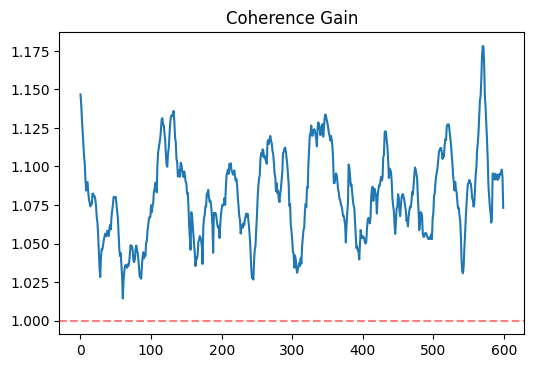

In [7]:
og = np.array(eval_sample)
rec = np.array(output_)
bin_size = 32
cc_og = compute_moving_coherence(og, bin_size)
cc_rec = compute_moving_coherence(rec, bin_size)
cc_gain = cc_rec / cc_og
plt.figure(dpi=100)
plt.plot(cc_gain)
plt.title("Coherence Gain")
plt.axhline(y=1,linestyle='--',alpha=0.5,color='r')

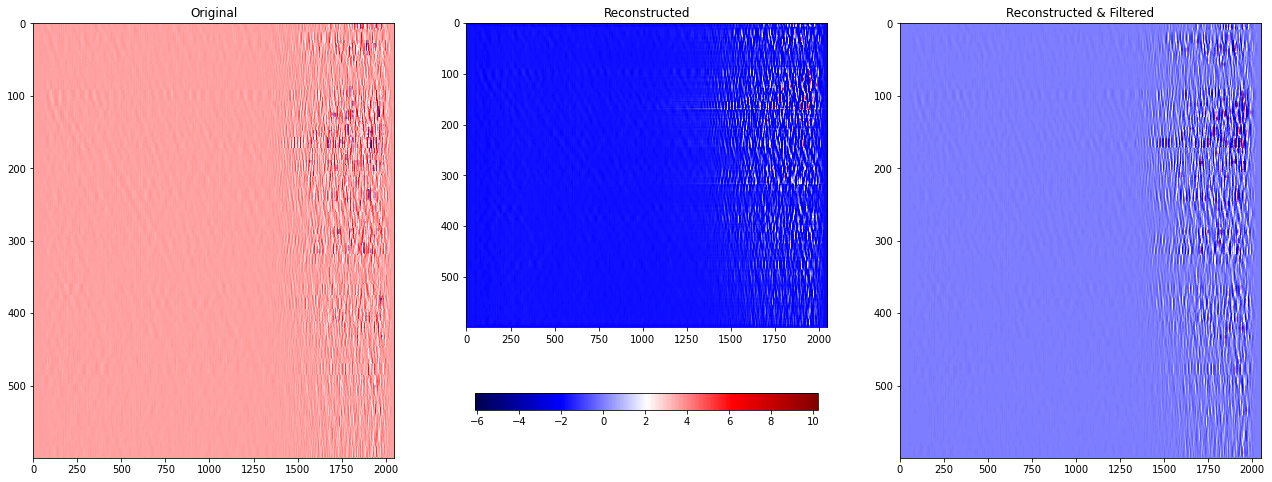

In [21]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22,8))
ax1.imshow(eval_sample, aspect='auto',interpolation='None',cmap='seismic')
ax1.set_title('Original')
ax2.imshow(output, aspect='auto',interpolation='None',cmap='seismic')
ax2.set_title('Reconstructed')
pl = ax3.imshow(taper_filter(output, 1, 10, sampleRate), aspect='auto',interpolation='None',cmap='seismic')
ax3.set_title('Reconstructed & Filtered')
cbar = fig.colorbar(pl, ax=ax2, shrink=0.95,orientation='horizontal')

## Wiggle for wiggle comparison

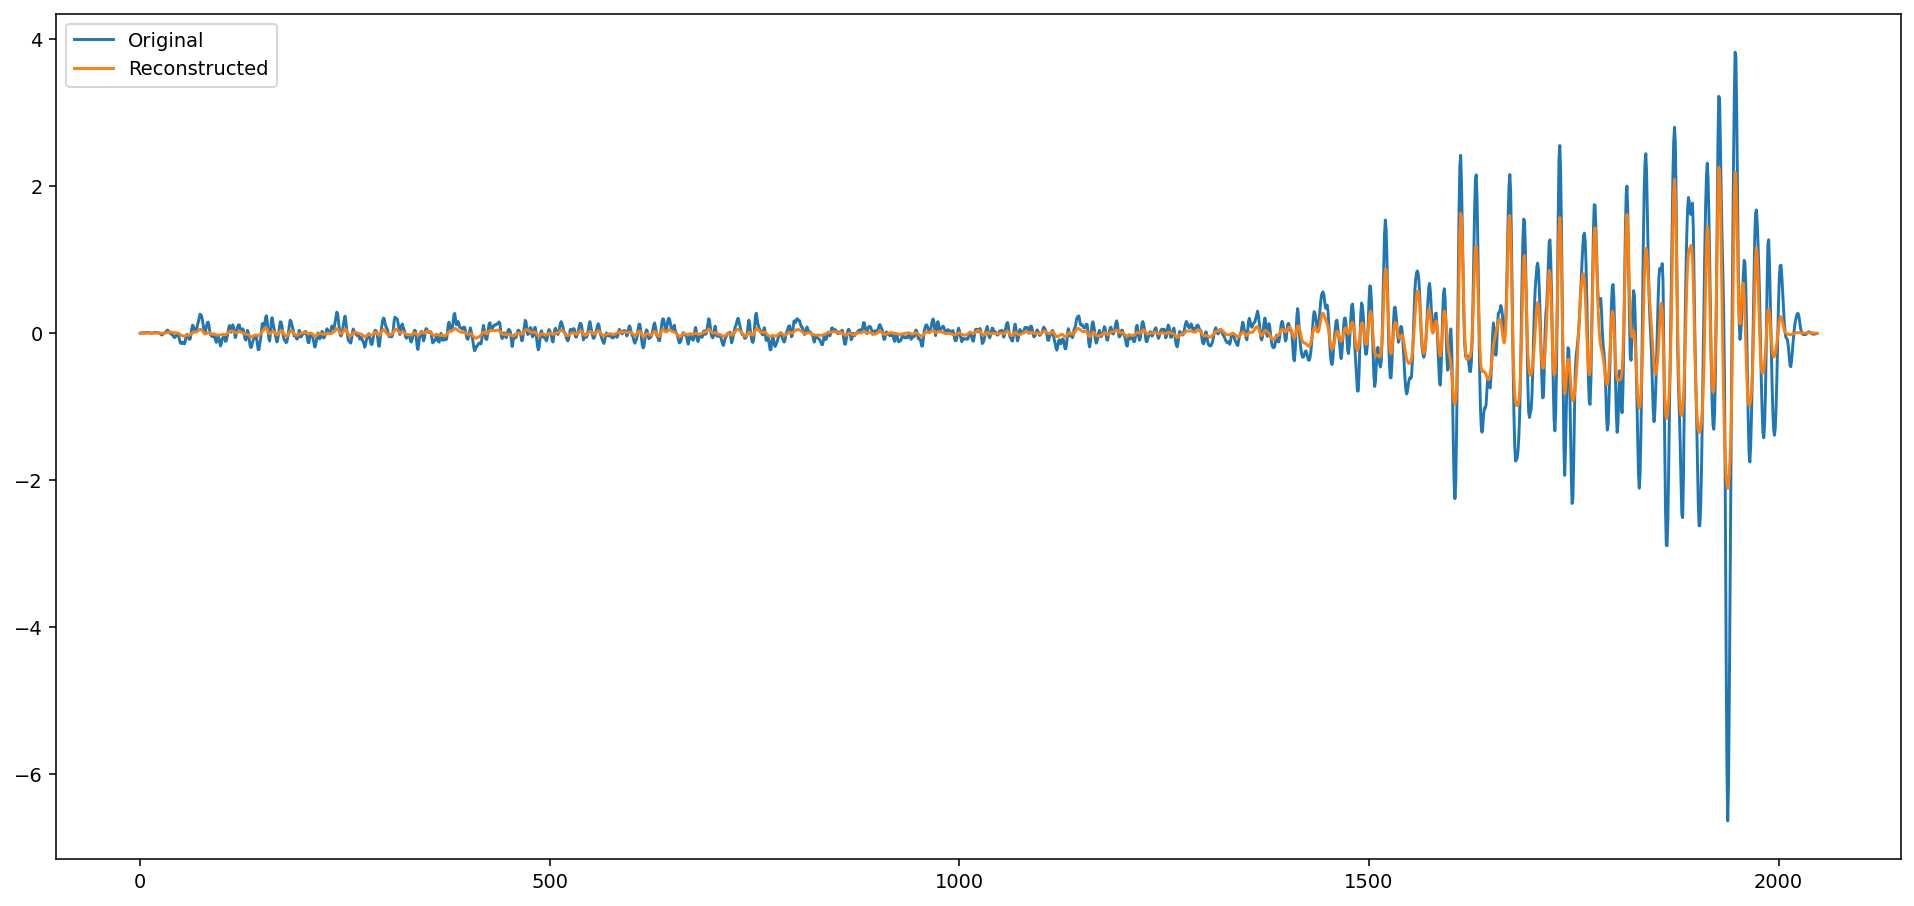

In [13]:
channel=500
plt.figure(figsize=(17,8),dpi=140)
plt.plot(eval_sample[channel],label='Original')
plt.plot(output_[channel],label='Reconstructed')
plt.legend()